In [1]:
%load_ext autoreload
%autoreload 2
import netCDF4
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants, split_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test, calculate_global_class_weights
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset, MultiXArrayDataset, MultiXArrayProbaDataset
from hmpai.data import SAT1_STAGES_ACCURACY, SAT_CLASSES_ACCURACY
from hmpai.visualization import plot_confusion_matrix
from hmpai.pytorch.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
# from braindecode.models.eegconformer import EEGConformer
from mne.io import read_info
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))
from hmpai.visualization import plot_predictions_on_epoch, predict_with_auc, show_lmer, set_seaborn_style, plot_tertile_split
import pandas as pd
from hmpai.behaviour.sat2 import read_behavioural_info, SAT2_SPLITS
from hmpai.pytorch.mamba import *
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

#### Create split of Low | Med | High for both conditions and save participant + epoch + split information

In [4]:
set_global_seed(42)
data_paths = [DATA_PATH / "sat2/stage_data_proba_250hz_step5_50.nc"]
# train_percentage=100 makes test and val 100 as well
splits = split_participants(data_paths, train_percentage=60)
splits = SAT2_SPLITS
labels = SAT_CLASSES_ACCURACY
whole_epoch = True
info_to_keep = ["rt", "participant", "epochs"]
subset_cond = None  # 'speed'|'accuracy'|None
skip_samples = 62 #62
cut_samples = 63 #63

In [5]:
norm_fn = norm_mad_zscore
# Shortcut so they dont have to be recalculated each time
statistics = {
    "global_min": -0.00014557216,
    "global_max": 0.00014740844,
    "global_mean": -2.277374212336032e-18,
    "global_std": 3.3968840765876904e-06,
    "global_median": 3.4879516e-11,
    "mad_score": 3.2237037e-06,
    "class_weights": Tensor([0.0, 0.0, 0.0, 0.0, 0.0]),
}

norm_vars = get_norm_vars_from_global_statistics(statistics, norm_fn)

train_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[0],
    normalization_fn=norm_fn,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    statistics=statistics,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
)
class_weights = train_data.statistics["class_weights"]
testval_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[1] + splits[2],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
)

In [6]:
behaviour_sat2 = read_behavioural_info(DATA_PATH / "sat2/behavioural/df_full.csv")
test_loader = DataLoader(
    testval_data, batch_size=128, shuffle=False, num_workers=8, pin_memory=True
)

In [7]:
chk_path = Path("../../models/mamba_low.pt")
checkpoint = load_model(chk_path)

model = base_mamba()
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)
model.eval();

In [8]:
data = predict_with_auc(model, test_loader, info_to_keep, SAT_CLASSES_ACCURACY)

data = data.merge(
    behaviour_sat2, left_on=["participant", "epochs"], right_on=["participant", "trial"]
)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971132/work/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,


In [9]:
data["confirmation_auc"] = data["confirmation_auc"] / data["rt_x"]
data["condition"] = data.groupby(["participant", "SAT"])["confirmation_auc"].transform(
    lambda x: pd.qcut(x, q=3, labels=["Low", "Medium", "High"])
)

<Axes: xlabel='condition', ylabel='response'>

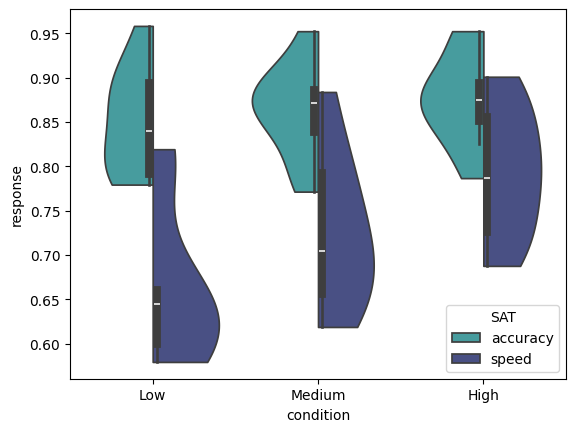

In [11]:
# Plot to check if result is the same
participant_ratios = (
    data.groupby(["participant", "SAT", "condition"], observed=True)
    .response.mean()
    .reset_index()
)
sns.violinplot(
    x="condition",
    y="response",
    data=participant_ratios,
    hue="SAT",
    split=True,
    palette="mako_r",
    cut=0,
)

In [13]:
# Subset and save split data
data = data[['participant', 'epochs', 'SAT', 'condition']]
data.to_csv("splits.csv", index=False)